In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow import keras
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
labels = [
    '1_finger',
    '2_finger',
    '3_finger',
    '4_finger',
    '5_finger',
    'okay',
    'thumbs_up',
    'thumbs_down',
    'call',
]
dataset = []

In [3]:
for i in labels:
#     if '.json' in i:
#         labels.append(i.split('.')[0])
    dataset.extend(json.loads(open('data/{}.json'.format(i)).read()))

In [4]:
X = []
Y = []
for i in dataset:
    X.append(i['flattened'])
    Y.append(i['label'])

In [10]:
Counter(Y)

Counter({'1_finger': 702,
         '2_finger': 645,
         '3_finger': 615,
         '4_finger': 628,
         '5_finger': 623,
         'okay': 641,
         'thumbs_up': 542,
         'thumbs_down': 544,
         'call': 539})

In [11]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

In [12]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=20)

In [13]:
Y_test[0].value_counts()

2_finger       137
1_finger       136
5_finger       130
4_finger       130
3_finger       126
okay           113
thumbs_down    112
thumbs_up      107
call           105
Name: 0, dtype: int64

In [14]:
df = pd.concat([X, Y], axis=1)

In [15]:
Y_train_ = np.array([labels.index(i[0]) for i in Y_train.values])
Y_test_ = np.array([labels.index(i[0]) for i in Y_test.values])

In [16]:
print(X_train.shape)
print(Y_train_.shape)

(4383, 42)
(4383,)


In [17]:
model = keras.Sequential()
model.add(keras.layers.Dense(24, input_shape=(42,)))
model.add(keras.layers.Dense(16,  activation='elu'))
# model.add(keras.layers.Dense(16,  activation='elu'))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(15))
# model.add(keras.layers.Dense(10, activation='relu'))
# model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(9))


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1032      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.fit(X_train.values, Y_train_, epochs=10)

Train on 4383 samples
Epoch 1/10
4383/4383 [==============================] - 0s 107us/sample - loss: 6.2188 - accuracy: 0.2685
Epoch 2/10
4383/4383 [==============================] - 0s 36us/sample - loss: 1.3232 - accuracy: 0.5624
Epoch 3/10
4383/4383 [==============================] - 0s 43us/sample - loss: 0.9205 - accuracy: 0.7089
Epoch 4/10
4383/4383 [==============================] - 0s 34us/sample - loss: 0.6982 - accuracy: 0.7901
Epoch 5/10
4383/4383 [==============================] - 0s 33us/sample - loss: 0.5480 - accuracy: 0.8446
Epoch 6/10
4383/4383 [==============================] - 0s 34us/sample - loss: 0.4578 - accuracy: 0.8725
Epoch 7/10
4383/4383 [==============================] - 0s 33us/sample - loss: 0.3942 - accuracy: 0.8928
Epoch 8/10
4383/4383 [==============================] - 0s 33us/sample - loss: 0.3380 - accuracy: 0.9065
Epoch 9/10
4383/4383 [==============================] - 0s 34us/sample - loss: 0.3042 - accuracy: 0.9190
Epoch 10/10
4383/4383 [=========

In [21]:
test_loss, test_acc = model.evaluate(X_test.values,  Y_test_, verbose=2)

1096/1096 - 0s - loss: 0.2529 - accuracy: 0.9343


In [22]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [23]:
predictions = probability_model.predict(X_test.values)

In [24]:
model.save('model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model2\assets


In [25]:
X_test.values.shape

(1096, 42)

In [26]:
len(predictions)

1096

In [27]:
p1 = np.array([np.argmax(i) for i in predictions])

In [28]:
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(Y_test_, p1).numpy(), index=labels, columns=labels)

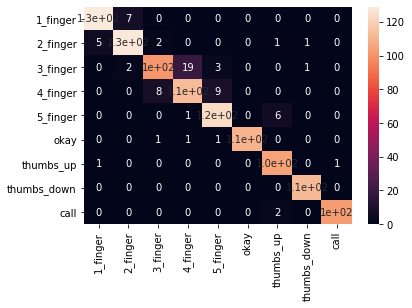

In [29]:
sns.heatmap(conf_matrix, annot=True)

In [5]:
model = tf.keras.models.load_model('model2')

In [6]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [7]:
import socketio
sio2 = socketio.Client()

In [8]:
@sio2.event
def connect():
    print('connection established')
    sio2.emit('model2')

@sio2.event
def disconnect():
    print('disconnected from server')
    
@sio2.event
def predict(data):
    predictions = probability_model.predict(np.array([data['m2']]))
    sio2.emit('predictions', {'preds': predictions.tolist()})

In [9]:
sio2.connect('http://127.0.0.1:8080')

connection established
disconnected from server
connection established


In [53]:
sio2.disconnect()